# Chapter 3: Your First GAN

In [1]:
%matplotlib inline

import matplotlib.pyplot as plt
import numpy as np

from keras.datasets import mnist
from keras.layers import Dense, Flatten, Reshape
from keras.layers.advanced_activations import LeakyReLU
from keras.models import Sequential
from keras.optimizers import Adam

/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
img_rows = 28
img_cols = 28
channels = 1

# Input image dimensions
img_shape = (img_rows, img_cols, channels)

# Size of the noise vector, used as input to the Generator
z_dim = 100

## Generator

In [3]:
def build_generator(img_shape, z_dim):

    model = Sequential()

    # Fully connected layer
    model.add(Dense(128, input_dim=z_dim))

    # Leaky ReLU activation
    model.add(LeakyReLU(alpha=0.01))

    # Output layer with tanh activation
    model.add(Dense(28 * 28 * 1, activation='tanh'))

    # Reshape the Generator output to image dimensions
    model.add(Reshape(img_shape))

    return model

## Discriminator

In [4]:
def build_discriminator(img_shape):

    model = Sequential()

    # Flatten the input image
    model.add(Flatten(input_shape=img_shape))

    # Fully connected layer
    model.add(Dense(128))

    # Leaky ReLU activation
    model.add(LeakyReLU(alpha=0.01))

    # Output layer with sigmoid activation
    model.add(Dense(1, activation='sigmoid'))

    return model

## Build the Model

In [5]:
def build_gan(generator, discriminator):

    model = Sequential()

    # Combined Generator -> Discriminator model
    model.add(generator)
    model.add(discriminator)

    return model

In [6]:
# Build and compile the Discriminator
discriminator = build_discriminator(img_shape)
discriminator.compile(loss='binary_crossentropy',
                      optimizer=Adam(),
                      metrics=['accuracy'])

# Build the Generator
generator = build_generator(img_shape, z_dim)

# Keep Discriminator’s parameters constant for Generator training
discriminator.trainable = False

# Build and compile GAN model with fixed Discriminator to train the Generator
gan = build_gan(generator, discriminator)
gan.compile(loss='binary_crossentropy', optimizer=Adam())

## Training

In [7]:
losses = []
accuracies = []
iteration_checkpoints = []


def train(iterations, batch_size, sample_interval):

    # Load the MNIST dataset
    (X_train, _), (_, _) = mnist.load_data()

    # Rescale [0, 255] grayscale pixel values to [-1, 1]
    X_train = X_train / 127.5 - 1.0
    X_train = np.expand_dims(X_train, axis=3)

    # Labels for real images: all ones
    real = np.ones((batch_size, 1))

    # Labels for fake images: all zeros
    fake = np.zeros((batch_size, 1))

    for iteration in range(iterations):

        # -------------------------
        #  Train the Discriminator
        # -------------------------

        # Get a random batch of real images
        idx = np.random.randint(0, X_train.shape[0], batch_size)
        imgs = X_train[idx]

        # Generate a batch of fake images
        z = np.random.normal(0, 1, (batch_size, 100))
        gen_imgs = generator.predict(z)

        # Train Discriminator
        d_loss_real = discriminator.train_on_batch(imgs, real)
        d_loss_fake = discriminator.train_on_batch(gen_imgs, fake)
        d_loss, accuracy = 0.5 * np.add(d_loss_real, d_loss_fake)

        # ---------------------
        #  Train the Generator
        # ---------------------

        # Generate a batch of fake images
        z = np.random.normal(0, 1, (batch_size, 100))
        gen_imgs = generator.predict(z)

        # Train Generator
        g_loss = gan.train_on_batch(z, real)

        if (iteration + 1) % sample_interval == 0:

            # Save losses and accuracies so they can be plotted after training
            losses.append((d_loss, g_loss))
            accuracies.append(100.0 * accuracy)
            iteration_checkpoints.append(iteration + 1)

            # Output training progress
            print("%d [D loss: %f, acc.: %.2f%%] [G loss: %f]" %
                  (iteration + 1, d_loss, 100.0 * accuracy, g_loss))

            # Output a sample of generated image
            sample_images(generator)

In [8]:
def sample_images(generator, image_grid_rows=4, image_grid_columns=4):

    # Sample random noise
    z = np.random.normal(0, 1, (image_grid_rows * image_grid_columns, z_dim))

    # Generate images from random noise
    gen_imgs = generator.predict(z)

    # Rescale image pixel values to [0, 1]
    gen_imgs = 0.5 * gen_imgs + 0.5

    # Set image grid
    fig, axs = plt.subplots(image_grid_rows,
                            image_grid_columns,
                            figsize=(4, 4),
                            sharey=True,
                            sharex=True)

    cnt = 0
    for i in range(image_grid_rows):
        for j in range(image_grid_columns):
            # Output a grid of images
            axs[i, j].imshow(gen_imgs[cnt, :, :, 0], cmap='gray')
            axs[i, j].axis('off')
            cnt += 1

## Train the GAN and Inspect Output

Note that the `'Discrepancy between trainable weights and collected trainable'` warning from Keras is expected. It is by design: The Generator's trainable parameters are intentionally held constant during Discriminator training, and vice versa.

/anaconda3/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


1000 [D loss: 0.079624, acc.: 98.05%] [G loss: 5.473911]
2000 [D loss: 0.051949, acc.: 98.83%] [G loss: 4.657489]
3000 [D loss: 0.136962, acc.: 94.53%] [G loss: 4.263645]
4000 [D loss: 0.111852, acc.: 95.70%] [G loss: 4.911368]
5000 [D loss: 0.212904, acc.: 91.80%] [G loss: 4.432818]
6000 [D loss: 0.203778, acc.: 92.58%] [G loss: 5.181444]
7000 [D loss: 0.232397, acc.: 89.84%] [G loss: 3.960130]
8000 [D loss: 0.369681, acc.: 86.33%] [G loss: 3.746047]
9000 [D loss: 0.327208, acc.: 86.72%] [G loss: 3.814270]
10000 [D loss: 0.314197, acc.: 87.89%] [G loss: 2.936252]
11000 [D loss: 0.252466, acc.: 89.45%] [G loss: 3.949617]
12000 [D loss: 0.373651, acc.: 85.55%] [G loss: 4.224548]
13000 [D loss: 0.406469, acc.: 81.25%] [G loss: 2.590958]
14000 [D loss: 0.329677, acc.: 86.33%] [G loss: 3.238721]
15000 [D loss: 0.460831, acc.: 80.47%] [G loss: 2.614445]
16000 [D loss: 0.358430, acc.: 85.94%] [G loss: 3.780541]
17000 [D loss: 0.207434, acc.: 91.80%] [G loss: 3.464233]
18000 [D loss: 0.270953

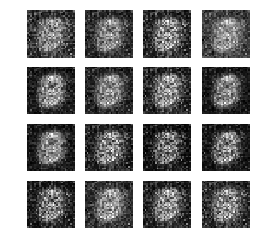

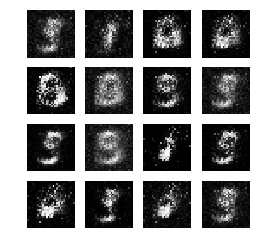

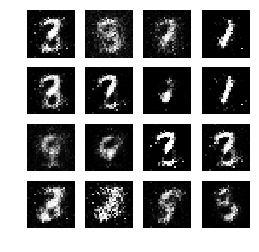

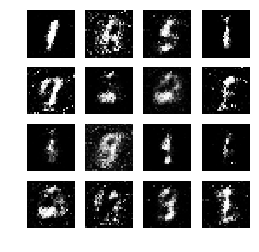

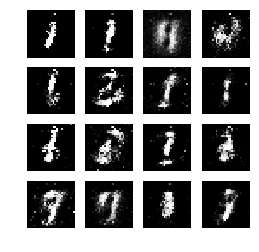

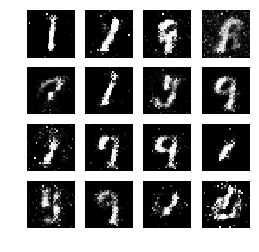

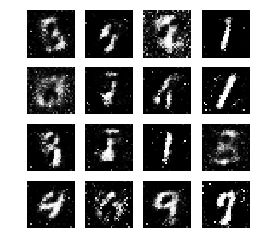

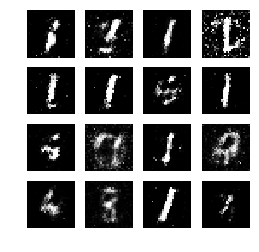

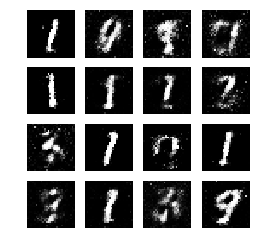

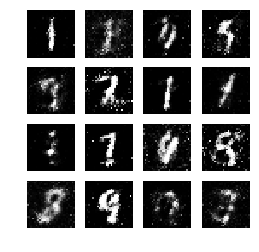

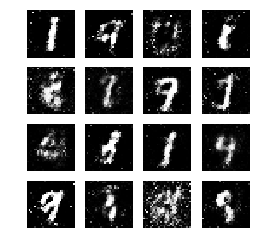

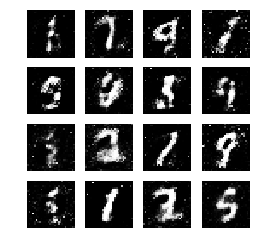

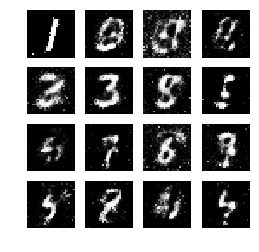

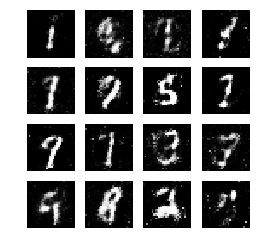

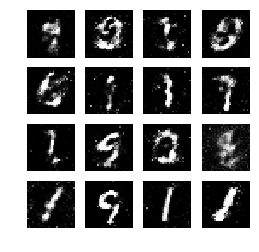

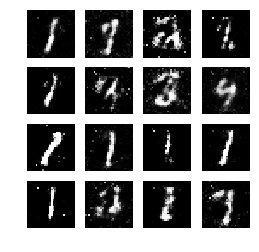

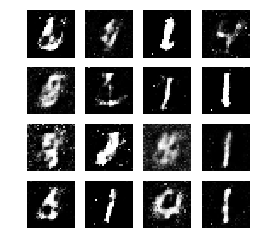

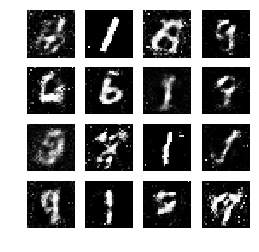

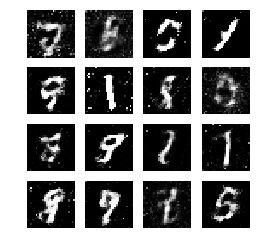

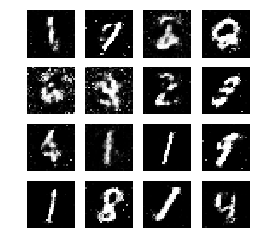

In [9]:
# Set hyperparameters
iterations = 20000
batch_size = 128
sample_interval = 1000

# Train the GAN for the specified number of iterations
train(iterations, batch_size, sample_interval)

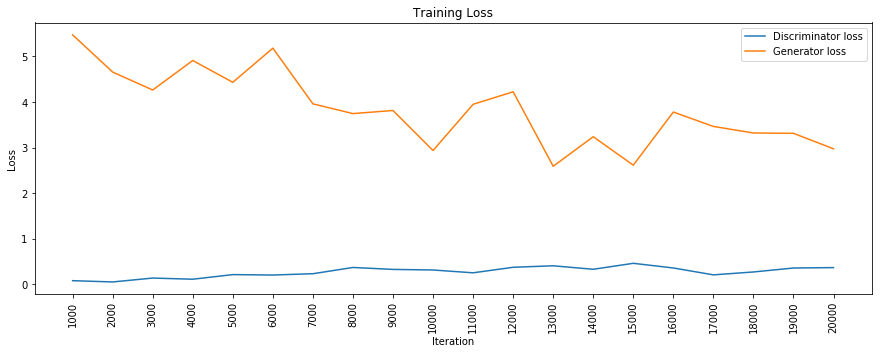

In [10]:
losses = np.array(losses)

# Plot training losses for Discriminator and Generator
plt.figure(figsize=(15, 5))
plt.plot(iteration_checkpoints, losses.T[0], label="Discriminator loss")
plt.plot(iteration_checkpoints, losses.T[1], label="Generator loss")

plt.xticks(iteration_checkpoints, rotation=90)

plt.title("Training Loss")
plt.xlabel("Iteration")
plt.ylabel("Loss")
plt.legend()

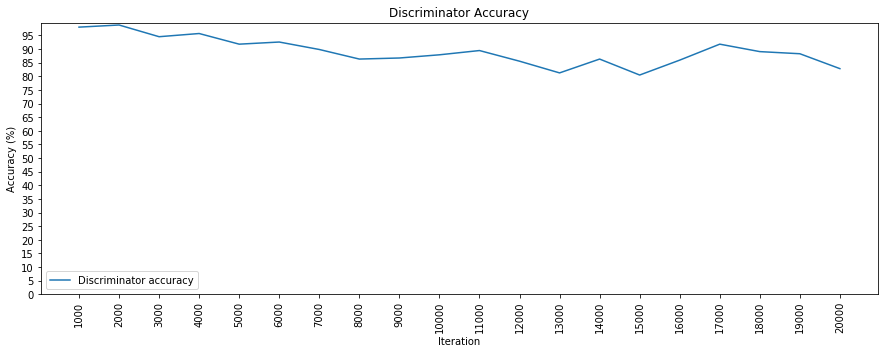

In [11]:
accuracies = np.array(accuracies)

# Plot Discriminator accuracy
plt.figure(figsize=(15, 5))
plt.plot(iteration_checkpoints, accuracies, label="Discriminator accuracy")

plt.xticks(iteration_checkpoints, rotation=90)
plt.yticks(range(0, 100, 5))

plt.title("Discriminator Accuracy")
plt.xlabel("Iteration")
plt.ylabel("Accuracy (%)")
plt.legend()

----